In [212]:
from matplotlib import pyplot as plt
import random
import itertools
from keras.datasets import mnist
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import time
import warnings

warnings.filterwarnings('ignore')

# SASVI

In [213]:
def get_a(lambda1, θ1star):
    return(-θ1star+y/lambda1)

def get_b(lambda2, θ1star):
    return(-θ1star+y/lambda2)

def x_ort(x,a,b):
    return(x-a*np.dot(a,x)/(np.linalg.norm(a)**2))

def xj_ort(x,j,a,b):
    return(x[:,j]-a*np.dot(x[:,j],a)/(np.linalg.norm(a)**2))

def y_ort(y,a,b):
    return(y-a*np.dot(y,a)/(np.linalg.norm(a)**2))

In [377]:
def sasvi(X,lambda1, lambda2, θ1star, verbose=False):

    
    uminus=np.zeros(len(X[1,:]))
    uplus=np.zeros(len(X[1,:]))
    to_keep=list(range(len(X[1,:])))
    to_drop=[]
    a=get_a(lambda1, θ1star)
    b=get_b(lambda2, θ1star)

    
    
    yort=y_ort(y,a,b)
    for j in range(len(X[1,:])):
        xjort=xj_ort(X,j,a,b)
        if(a.any()!=0 and np.dot(b,a)/(np.linalg.norm(b)*np.linalg.norm(a))>np.abs(np.dot(X[:,j],a))/(np.linalg.norm(X[:,j])*np.linalg.norm(a))):
            uplus[j]=np.dot(X[:,j],θ1star)+(1/lambda2-1/lambda1)/2*(np.linalg.norm(xjort)*np.linalg.norm(yort)+np.dot(xjort,yort))
            uminus[j]=-np.dot(X[:,j],θ1star)+(1/lambda2-1/lambda1)/2*(np.linalg.norm(xjort)*np.linalg.norm(yort)-np.dot(xjort,yort))

        elif(np.dot(X[:,j],a)>0 and np.dot(b,a)/(np.linalg.norm(b)*np.linalg.norm(a))<=np.dot(X[:,j],a)/(np.linalg.norm(X[:,j])*np.linalg.norm(a))):
            uplus[j]=np.dot(X[:,j],θ1star)+(1/lambda2-1/lambda1)/2*(np.linalg.norm(xjort)*np.linalg.norm(yort)+np.dot(xjort,yort))
            uminus[j]=-np.dot(X[:,j],θ1star)+1/2*(np.linalg.norm(X[:,j])*np.linalg.norm(b)-np.dot(X[:,j],b))

        elif(np.dot(X[:,j],a)<0 and np.dot(b,a)/(np.linalg.norm(b)*np.linalg.norm(a))<=-np.dot(X[:,j],a)/(np.linalg.norm(X[:,j])*np.linalg.norm(a))):
            uplus[j]=np.dot(X[:,j],θ1star)+1/2*(np.linalg.norm(X[:,j])*np.linalg.norm(b)+np.dot(X[:,j],b))
            uminus[j]=-np.dot(X[:,j],θ1star)+(1/lambda2-1/lambda1)/2*(np.linalg.norm(xjort)*np.linalg.norm(yort)-np.dot(xjort,yort))

        elif(a.all()==0):
            uminus[j]=-np.dot(X[:,j],θ1star)+1/2*(np.linalg.norm(X[:,j])*np.linalg.norm(b)-np.dot(X[:,j],b))
            uplus[j]=np.dot(X[:,j],θ1star)+1/2*(np.linalg.norm(X[:,j])*np.linalg.norm(b)+np.dot(X[:,j],b))

        if(np.max([uminus[j],uplus[j]])<1):
            if verbose:
                print("Dropping the {}th composant".format(j))
            to_keep.remove(j)
            to_drop.append(j)
    new_X=X[:,to_keep]
    return(new_X,to_drop)

# MNIST example

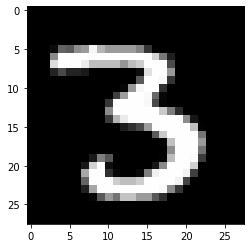

In [378]:
plt.imshow(train_X[12], cmap=plt.get_cmap('gray'))

In [379]:
def gen_data_MNIST():
    (train_X, train_y), (test_X, test_y) = mnist.load_data()
    ind=[[]]*10
    for i in range(10):
        ind[i]=random.sample([j for j in range(np.shape(train_X)[0]) if train_y[j]==i],5000)
    ind=list(itertools.chain.from_iterable(ind))
    X=np.zeros([784,50000])
    for i in range(50000):
        X[:,i]=train_X[ind[i]].flatten()
    y=test_X[random.sample(range(np.shape(test_y)[0]),1)[0]].flatten()
    return(X,y)

In [380]:
[X,y]=gen_data_MNIST()

In [387]:
λ_max=np.max(np.abs(np.dot(y,X)))
λ=np.linspace(1,0.05,20)*λ_max
β=np.zeros(50000)
Tsasvi=[]
Tnormal=[]
Tscreening=[]
nb_removed=[]

for i in range(len(λ)-1):
    print("#### Step n°{}/{} ####".format(i+1,len(λ)-1))
    θ1star=(y-np.dot(X,β))/λ[i]
    start=time.time()
    [X_new,to_drop]=sasvi(X,λ[i], λ[i+1], θ1star, verbose=False)
    Tscreening.append(time.time()-start)
    nb_removed.append(len(to_drop))
    print("Number of removed variables :",len(to_drop))
    print("Sum of betas to drop :",np.sum(β[to_drop]))
        
    start=time.time()
    clf = linear_model.Lasso(alpha=λ[i+1])
    clf.fit(X_new,y)
    Tsasvi.append(time.time()-start)
    
    start=time.time()
    clf = linear_model.Lasso(alpha=λ[i+1])
    clf.fit(X,y)
    Tnormal.append(time.time()-start)
    β=clf.coef_

#### Step n°1/19 ####
Number of removed variables : 49976
Sum of betas to drop : 0.0
(784, 50000)
#### Step n°2/19 ####
Number of removed variables : 49926
Sum of betas to drop : 0.0
(784, 50000)
#### Step n°3/19 ####
Number of removed variables : 49758
Sum of betas to drop : 0.0
(784, 50000)
#### Step n°4/19 ####
Number of removed variables : 49475
Sum of betas to drop : 0.0
(784, 50000)
#### Step n°5/19 ####
Number of removed variables : 48830
Sum of betas to drop : 0.0
(784, 50000)
#### Step n°6/19 ####
Number of removed variables : 47777
Sum of betas to drop : 0.0
(784, 50000)
#### Step n°7/19 ####
Number of removed variables : 46065
Sum of betas to drop : 0.0
(784, 50000)
#### Step n°8/19 ####
Number of removed variables : 43359
Sum of betas to drop : 0.0
(784, 50000)
#### Step n°9/19 ####
Number of removed variables : 39491
Sum of betas to drop : 0.0
(784, 50000)
#### Step n°10/19 ####
Number of removed variables : 34514
Sum of betas to drop : 0.0
(784, 50000)
#### Step n°11/19 #

Text(0, 0.5, 'Nb removed/Total nb of variables')

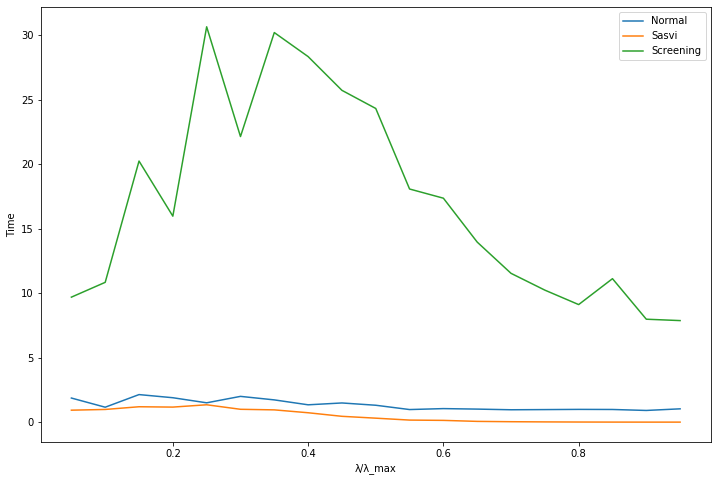

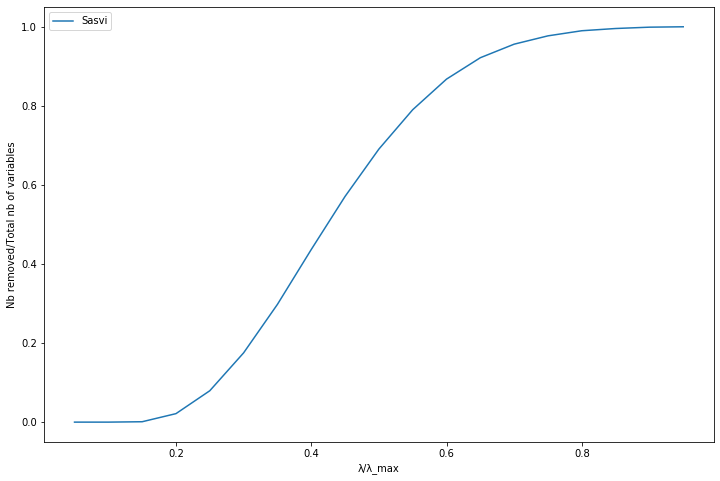

In [389]:
plt.figure(figsize=(12,8))
plt.plot(λ[list(range(1,len(Tnormal)+1))]/λ_max,Tnormal,label='Normal')
plt.plot(λ[list(range(1,len(Tnormal)+1))]/λ_max,Tsasvi,label='Sasvi')
plt.plot(λ[list(range(1,len(Tnormal)+1))]/λ_max,Tscreening,label='Screening')
plt.legend()
plt.xlabel("λ/λ_max")
plt.ylabel("Time")

plt.figure(figsize=(12,8))
plt.plot(λ[list(range(1,len(Tnormal)+1))]/λ_max,np.array(nb_removed)/50000,label='Sasvi')
plt.legend()
plt.xlabel("λ/λ_max")
plt.ylabel("Nb removed/Total nb of variables")

In [ ]:
X_sasvi_train, X_sasvi_test, y_sasvi_train, y_sasvi_test=train_test_split(X_previous, y, test_size=0.2, random_state=0)
clf_sasvi = linear_model.Lasso(alpha=λ2)
clf_sasvi.fit(X_sasvi_train,y_sasvi_train)
#scores_sasvi.append(np.mean(cross_val_score(clf_sasvi, X_sasvi, y, cv=5)))